# Notebook for predicting WAR from features via simple linear regression

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [67]:
# Load the by-year data (using retry files with fixed WAR merging)
data_yr = pd.read_csv("data/Hitters_2023-24_byYear_retry.csv")
print(f"Total rows: {len(data_yr)}")
print(f"Years available: {sorted(data_yr['year'].dropna().unique())}")
print(f"Players with 2025 data: {len(data_yr[data_yr['year'] == 2025]['mlbID'].unique())}")
print(f"Rows with WAR: {data_yr['WAR'].notna().sum()} / {len(data_yr)} ({data_yr['WAR'].notna().sum()/len(data_yr)*100:.1f}%)")
data_yr.head()

Total rows: 1850
Years available: [2023.0, 2024.0, 2025.0]
Players with 2025 data: 251
Rows with WAR: 1850 / 1850 (100.0%)


,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Season,WAR
0,CJ Abrams,22,791,Maj-NL,Washington,151,614,563,83,138,...,120.0,WSH,SS,22.0,222.0,13.0,4.22,28.6,2023,3.45
1,Jos\xc3\xa9 Abreu,36,769,Maj-AL,Houston,152,642,584,68,141,...,117.0,HOU,1B,36.0,210.0,NaN,4.76,25.5,2023,-0.09
2,Wilyer Abreu,24,791,Maj-AL,Boston,28,85,76,10,24,...,111.0,BOS,CF,24.0,26.0,NaN,NaN,26.7,2023,0.67
3,Ronald Acu\xc3\xb1a Jr.,25,780,Maj-NL,Atlanta,163,752,657,152,219,...,144.0,ATL,RF,25.0,296.0,18.0,4.35,28.0,2023,8.40
4,Willy Adames,27,788,Maj-NL,Milwaukee,151,646,560,73,124,...,158.0,MIL,SS,27.0,176.0,NaN,4.43,27.6,2023,2.91


In [68]:
# Separate data into 2023-2024 (features) and 2025 (target)
data_2023_2024 = data_yr[data_yr['year'].isin([2023, 2024])].copy()
data_2025 = data_yr[data_yr['year'] == 2025].copy()

print(f"2023-2024 rows: {len(data_2023_2024)}")
print(f"2025 rows: {len(data_2025)}")
print(f"Unique players in 2023-2024: {data_2023_2024['mlbID'].nunique()}")
print(f"Unique players in 2025: {data_2025['mlbID'].nunique()}")

# Find players who have both 2023-2024 and 2025 data
players_with_2025 = set(data_2025['mlbID'].unique())
players_with_2023_2024 = set(data_2023_2024['mlbID'].unique())
common_players = players_with_2025.intersection(players_with_2023_2024)
print(f"Players with both 2023-2024 and 2025 data: {len(common_players)}")

2023-2024 rows: 510
2025 rows: 251
Unique players in 2023-2024: 332
Unique players in 2025: 251
Players with both 2023-2024 and 2025 data: 199


In [69]:
# Identify feature columns (exclude identifiers, year, and target)
exclude_cols = ['Name', 'mlbID', 'year', 'Season', 'WAR', 'Name_bat', 'Name_ev', 'Name_x', 
                'Name_sprint', 'Lev', 'Tm', 'team', 'position', 'team_id']

# Get numeric columns that could be features
numeric_cols = data_2023_2024.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols and col != 'WAR']

print(f"Number of potential features: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:10]}")


Number of potential features: 72
Sample features: ['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR']


In [70]:
# For each player, average their 2023-2024 features (handling NaN appropriately)
# We'll average numeric features, but need to be careful about which ones to average vs sum

def average_features_by_player(df, player_id_col='mlbID', feature_cols=None):
    """
    Average features across years for each player.
    Handles NaN by only averaging non-NaN values.
    """
    if feature_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude_cols = ['year', 'Season', 'WAR']
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Group by player and average (NaN values are ignored in mean calculation)
    averaged = df.groupby(player_id_col)[feature_cols].mean().reset_index()
    
    # Also get player name for reference
    if 'Name' in df.columns:
        name_map = df.groupby(player_id_col)['Name'].first().reset_index()
        averaged = averaged.merge(name_map, on=player_id_col, how='left')
    
    return averaged

# Average 2023-2024 features for each player (for training)
features_avg_train = average_features_by_player(data_2023_2024, feature_cols=feature_cols)
print(f"Training features shape (2023-2024 averaged): {features_avg_train.shape}")

# Also average 2023-2024 features for players who have 2025 data (for prediction)
# This will be the same as features_avg_train, but we'll use it for consistency
features_avg = features_avg_train.copy()
print(f"Prediction features shape: {features_avg.shape}")
features_avg.head()


Training features shape (2023-2024 averaged): (332, 74)
Prediction features shape: (332, 74)


,mlbID,Age,#days,G,PA,AB,R,H,2B,3B,...,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Name
0,408234,40.0,791.0,98.0,370.0,334.0,21.0,86.0,20.0,0.0,...,-0.0100,0.2990,0.301,-0.0020,40.0,127.0,NaN,5.090,23.1,Miguel Cabrera
1,444482,35.0,781.0,136.0,428.0,400.0,47.0,103.0,26.0,1.0,...,-0.0190,0.2900,0.309,-0.0190,35.0,195.0,NaN,4.520,27.0,David Peralta
2,453568,36.5,609.0,110.0,456.0,404.0,58.0,107.5,24.0,5.0,...,0.0405,0.3365,0.322,0.0145,36.5,160.0,NaN,4.375,27.5,Charlie Blackmon
3,455117,36.0,769.0,127.0,441.0,390.0,35.0,73.0,12.0,0.0,...,-0.0090,0.2660,0.267,-0.0010,36.0,86.0,NaN,5.050,23.2,Mart\xc3\xadn Maldonado
4,456781,35.0,781.0,139.0,463.0,404.0,44.0,112.0,26.0,1.0,...,-0.0380,0.3380,0.351,-0.0130,35.0,141.0,NaN,4.750,25.4,Donovan Solano


In [71]:
# Prepare training data: 2023-2024 features -> 2023-2024 WAR per 162
# For each player in 2023-2024, calculate their WAR per 162
data_2023_2024_with_war = data_2023_2024.copy()
data_2023_2024_with_war['WAR_per_162'] = (data_2023_2024_with_war['WAR'] / data_2023_2024_with_war['G'].replace(0, pd.NA)) * 162

# Average WAR per 162 across 2023-2024 for each player (for training target)
war_per_162_train = data_2023_2024_with_war.groupby('mlbID')['WAR_per_162'].mean().reset_index()
war_per_162_train.columns = ['mlbID', 'WAR_per_162_train']

# Merge training features with training target
train_data = features_avg_train.merge(war_per_162_train, on='mlbID', how='inner')

print("Training Data (2023-2024):")
print(f"Shape: {train_data.shape}")
print(f"Players: {len(train_data)}")
print(f"\nWAR_per_162 (2023-2024 averaged) stats:")
print(train_data['WAR_per_162_train'].describe())
print(f"\nNaN in training target: {train_data['WAR_per_162_train'].isna().sum()}")

# Prepare test data: 2023-2024 features -> 2025 WAR per 162
# Ensure we have all required columns from data_2025
required_cols = ['mlbID', 'WAR', 'G', 'Name']
# Check which columns actually exist
available_cols = [col for col in required_cols if col in data_2025.columns]
target_2025 = data_2025[available_cols].copy()

# Calculate WAR per 162 games (handle division by zero)
if 'G' in target_2025.columns and 'WAR' in target_2025.columns:
    target_2025['WAR_per_162_2025'] = (target_2025['WAR'] / target_2025['G'].replace(0, pd.NA)) * 162
else:
    raise ValueError("Required columns 'G' or 'WAR' not found in data_2025")

# Merge features with 2025 target (for evaluation)
# Don't include 'G' from target_2025 since features_avg already has 'G' (from 2023-2024)
# We only need WAR_per_162_2025 and WAR for evaluation
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
test_data = features_avg.merge(target_2025[merge_cols], on='mlbID', how='inner')

print("\nTest Data (2025):")
print(f"Shape: {test_data.shape}")
print(f"Players: {len(test_data)}")
print(f"\nWAR_per_162_2025 stats:")
print(test_data['WAR_per_162_2025'].describe())
print(f"\nNaN in test target: {test_data['WAR_per_162_2025'].isna().sum()}")

train_data.head()


Training Data (2023-2024):
Shape: (332, 75)
Players: 332

WAR_per_162 (2023-2024 averaged) stats:
count    332.000000
mean       2.441736
std        1.955946
min       -2.331220
25%        1.163624
50%        2.378709
75%        3.603778
max        8.577061
Name: WAR_per_162_train, dtype: float64

NaN in training target: 0

Test Data (2025):
Shape: (199, 76)
Players: 199

WAR_per_162_2025 stats:
count    199.000000
mean       2.726722
std        2.137518
min       -2.466486
25%        1.326765
50%        2.392450
75%        3.954027
max        9.883019
Name: WAR_per_162_2025, dtype: float64

NaN in test target: 0


,mlbID,Age,#days,G,PA,AB,R,H,2B,3B,...,woba,est_woba,est_woba_minus_woba_diff,age,competitive_runs,bolts,hp_to_1b,sprint_speed,Name,WAR_per_162_train
0,408234,40.0,791.0,98.0,370.0,334.0,21.0,86.0,20.0,0.0,...,0.2990,0.301,-0.0020,40.0,127.0,NaN,5.090,23.1,Miguel Cabrera,-0.495918
1,444482,35.0,781.0,136.0,428.0,400.0,47.0,103.0,26.0,1.0,...,0.2900,0.309,-0.0190,35.0,195.0,NaN,4.520,27.0,David Peralta,0.881471
2,453568,36.5,609.0,110.0,456.0,404.0,58.0,107.5,24.0,5.0,...,0.3365,0.322,0.0145,36.5,160.0,NaN,4.375,27.5,Charlie Blackmon,1.592782
3,455117,36.0,769.0,127.0,441.0,390.0,35.0,73.0,12.0,0.0,...,0.2660,0.267,-0.0010,36.0,86.0,NaN,5.050,23.2,Mart\xc3\xadn Maldonado,0.420945
4,456781,35.0,781.0,139.0,463.0,404.0,44.0,112.0,26.0,1.0,...,0.3380,0.351,-0.0130,35.0,141.0,NaN,4.750,25.4,Donovan Solano,1.864748


In [72]:
# Prepare training features and target (2023-2024)
train_data_clean = train_data.dropna(subset=['WAR_per_162_train']).copy()
# Only select feature columns that actually exist in the dataframe
available_train_features = [col for col in feature_cols if col in train_data_clean.columns]
X_train_full = train_data_clean[available_train_features].copy()
y_train_full = train_data_clean['WAR_per_162_train'].copy()

# Prepare test features and target (2025)
test_data_clean = test_data.dropna(subset=['WAR_per_162_2025']).copy()

# Debug: Check which feature columns are missing
missing_features = [col for col in feature_cols if col not in test_data_clean.columns]
if missing_features:
    print(f"Warning: {len(missing_features)} features missing from test_data: {missing_features[:10]}")

# Only select feature columns that actually exist in the dataframe
available_test_features = [col for col in feature_cols if col in test_data_clean.columns]
X_test = test_data_clean[available_test_features].copy()
y_test = test_data_clean['WAR_per_162_2025'].copy()

# Ensure both have the same features (use intersection)
common_features = list(set(available_train_features) & set(available_test_features))
X_train_full = X_train_full[common_features].copy()
X_test = X_test[common_features].copy()

print(f"Training set: {X_train_full.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Common features used: {len(common_features)}")
if len(common_features) < len(feature_cols):
    missing = set(feature_cols) - set(common_features)
    print(f"Features excluded (not in both datasets): {missing}")

# Handle NaN in features - we'll use median imputation for missing values
from sklearn.impute import SimpleImputer

# Fit imputer on training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)

# Transform test data with the same imputer
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\nTraining NaN after imputation: {X_train_imputed.isna().sum().sum()}")
print(f"Test NaN after imputation: {X_test_imputed.isna().sum().sum()}")

# For consistency with variable names in later cells
X_train = X_train_imputed
y_train = y_train_full
X_test = X_test_imputed


Training set: 332 samples
Test set: 199 samples
Common features used: 72

Training NaN after imputation: 0
Test NaN after imputation: 0


In [73]:
# Train simple linear regression on 2023-2024 data
# Model learns: 2023-2024 features -> 2023-2024 WAR per 162
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
# Training predictions (on 2023-2024 data)
y_train_pred = lr_model.predict(X_train)

# Test predictions (on 2025 data, using 2023-2024 features)
y_test_pred = lr_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"\nTraining (2023-2024 WAR per 162):")
print(f"  RMSE: {train_rmse:.3f}")
print(f"  MAE: {train_mae:.3f}")
print(f"  R²: {train_r2:.3f}")
print(f"\nTest (2025 WAR per 162):")
print(f"  RMSE: {test_rmse:.3f}")
print(f"  MAE: {test_mae:.3f}")
print(f"  R²: {test_r2:.3f}")


Model Performance:

Training (2023-2024 WAR per 162):
  RMSE: 1.013
  MAE: 0.821
  R²: 0.731

Test (2025 WAR per 162):
  RMSE: 1.997
  MAE: 1.567
  R²: 0.123


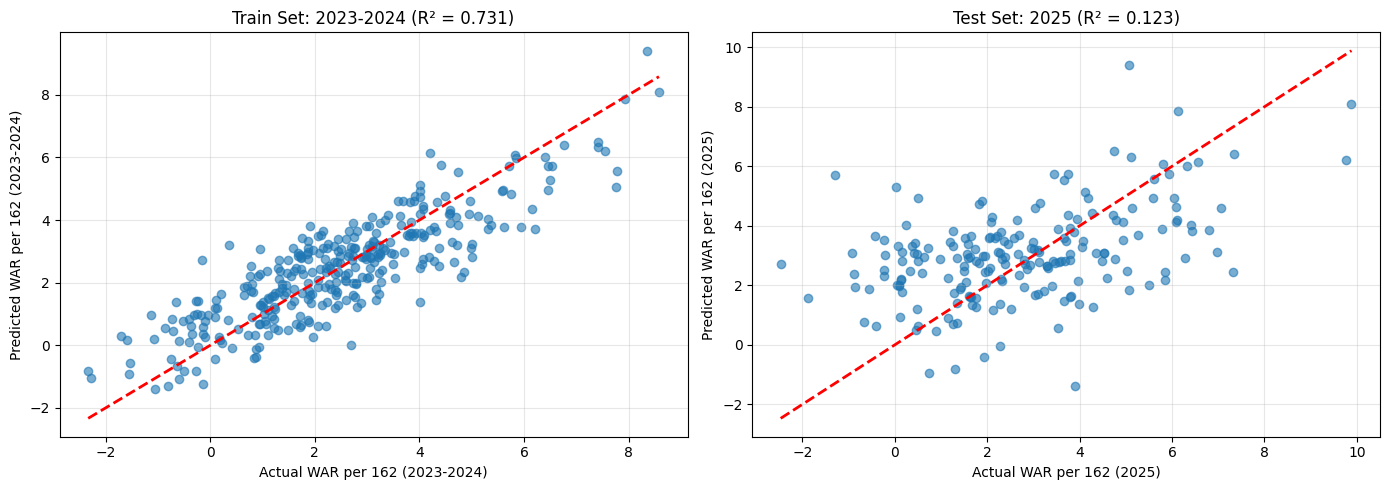

In [74]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set (2023-2024)
axes[0].scatter(y_train, y_train_pred, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual WAR per 162 (2023-2024)')
axes[0].set_ylabel('Predicted WAR per 162 (2023-2024)')
axes[0].set_title(f'Train Set: 2023-2024 (R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set (2025)
axes[1].scatter(y_test, y_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual WAR per 162 (2025)')
axes[1].set_ylabel('Predicted WAR per 162 (2025)')
axes[1].set_title(f'Test Set: 2025 (R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [75]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_
})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Top 20 Most Important Features (by absolute coefficient):")
print(feature_importance.head(20))


Top 20 Most Important Features (by absolute coefficient):
                        feature  coefficient  abs_coefficient
30                          SLG  -114.745725       114.745725
41     est_woba_minus_woba_diff   -70.857416        70.857416
69                          OPS    66.656727        66.656727
5                          woba   -53.626953        53.626953
26                          slg    52.122438        52.122438
40       est_slg_minus_slg_diff    35.657717        35.657717
39         est_ba_minus_ba_diff    32.843311        32.843311
2                        est_ba   -25.823517        25.823517
31              blast_per_swing   -20.492812        20.492812
23        blast_per_bat_contact    17.295970        17.295970
70                     est_woba    17.230463        17.230463
71                      est_slg    16.464721        16.464721
43         squared_up_per_swing    15.247191        15.247191
13   squared_up_per_bat_contact    -9.168223         9.168223
64          

In [76]:
# Make predictions for all players with 2023-2024 data (even if they don't have 2025 data)
# Model was trained on 2023-2024, now predicting 2025 WAR per 162

# Prepare all players' features (2023-2024 averaged)
# Use the same feature columns that were used for training
all_players_features = features_avg[common_features].copy()
all_players_features_imputed = pd.DataFrame(
    imputer.transform(all_players_features),
    columns=all_players_features.columns,
    index=all_players_features.index
)

# Make predictions (these are WAR per 162 for 2025)
all_predictions = lr_model.predict(all_players_features_imputed)

# Create results dataframe
predictions_df = features_avg[['mlbID', 'Name']].copy()
predictions_df['predicted_WAR_per_162_2025'] = all_predictions

# Recreate target_2025 to ensure it has all needed columns (in case cell 6 wasn't run)
target_2025_for_merge = data_2025[['mlbID', 'WAR', 'G', 'Name']].copy()
target_2025_for_merge['WAR_per_162_2025'] = (target_2025_for_merge['WAR'] / target_2025_for_merge['G'].replace(0, pd.NA)) * 162

# Merge with actual 2025 WAR per 162 if available
# Don't include 'G' in merge since predictions_df (from features_avg) already has 'G' from 2023-2024
# This avoids G_x/G_y column name conflict
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
predictions_df = predictions_df.merge(
    target_2025_for_merge[merge_cols], 
    on='mlbID', 
    how='left'
)

# Add G_2025 separately if needed (rename to avoid conflict with G from features_avg)
if 'G' in target_2025_for_merge.columns:
    g_2025_data = target_2025_for_merge[['mlbID', 'G']].copy()
    g_2025_data = g_2025_data.rename(columns={'G': 'G_2025'})
    predictions_df = predictions_df.merge(g_2025_data, on='mlbID', how='left')

# Sort by predicted WAR per 162
predictions_df = predictions_df.sort_values('predicted_WAR_per_162_2025', ascending=False)

# Print results - include G from features_avg and G_2025 if available
print_cols = ['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'WAR']
if 'G' in predictions_df.columns:
    print_cols.append('G')
if 'G_2025' in predictions_df.columns:
    print_cols.append('G_2025')

print("Top 20 Predicted WAR per 162 2025:")
print(predictions_df.head(20)[print_cols].to_string(index=False))

print(f"\nTotal players with predictions: {len(predictions_df)}")
print(f"Players with actual 2025 WAR per 162: {predictions_df['WAR_per_162_2025'].notna().sum()}")


Top 20 Predicted WAR per 162 2025:
                      Name  predicted_WAR_per_162_2025  WAR_per_162_2025   WAR  G_2025
   Ronald Acu\xc3\xb1a Jr.                    9.405021          5.064632  2.97    95.0
               Aaron Judge                    8.100618          9.883019  9.70   159.0
             Shohei Ohtani                    7.849340          6.128229  6.62   175.0
              Mookie Betts                    6.499898          4.743593  4.89   167.0
            Bobby Witt Jr.                    6.402987          7.336433  7.11   157.0
               Kyle Tucker                    6.318832          5.118750  4.55   144.0
              Corey Seager                    6.201114          9.767647  6.15   102.0
            Corbin Carroll                    6.129105          6.559301  5.79   143.0
Jos\xc3\xa9 Ram\xc3\xadrez                    6.074371          5.815901  5.78   161.0
                 Juan Soto                    6.023193          6.318000  6.24   160.0
        

In [77]:
# Compare predictions vs actual for players with 2025 data
# This is the same as the test set evaluation, but showing individual player errors
comparison = predictions_df[predictions_df['WAR_per_162_2025'].notna()].copy()
comparison['error'] = comparison['predicted_WAR_per_162_2025'] - comparison['WAR_per_162_2025']
comparison['abs_error'] = np.abs(comparison['error'])

print("Players with largest prediction errors (2025):")
print(comparison.nlargest(10, 'abs_error')[['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'error']].to_string(index=False))

print(f"\nMean Absolute Error (all players with 2025 data): {comparison['abs_error'].mean():.3f}")
print(f"RMSE (all players with 2025 data): {np.sqrt((comparison['error']**2).mean()):.3f}")
print(f"\nNote: Model trained on 2023-2024 WAR per 162, evaluated on 2025 WAR per 162")


Players with largest prediction errors (2025):
                   Name  predicted_WAR_per_162_2025  WAR_per_162_2025     error
            Nolan Jones                    5.717617         -1.286471  7.004088
             Brett Baty                   -1.389241          3.905581 -5.294823
            Matt McLain                    5.293347          0.032617  5.260729
          Jordan Walker                    2.727393         -2.466486  5.193879
     Jeremy Pe\xc3\xb1a                    2.458711          7.309440 -4.850729
            Jose Altuve                    4.920809          0.512129  4.408680
Ronald Acu\xc3\xb1a Jr.                    9.405021          5.064632  4.340390
              JJ Bleday                    3.646457         -0.429796  4.076253
          Nick Gonzales                    3.096873         -0.928125  4.024998
            Cal Raleigh                    3.108753          6.982105 -3.873352

Mean Absolute Error (all players with 2025 data): 1.567
RMSE (all player